In [ ]:
from utilities import *

In [54]:
import requests
import h3
import geopandas as gpd
from shapely.geometry import Polygon
import h3
import time

params = {
    "app_id": app_id,
    "app_key": app_key
}


def request_api(from_lat, from_lon, to_lat, to_lon, params=params):
    # Wysłanie zapytania
    url = f"https://api.tfl.gov.uk/Journey/JourneyResults/{from_lat},{from_lon}/to/{to_lat},{to_lon}"
    response = requests.get(url, params=params)

    # Sprawdzenie odpowiedzi
    if response.status_code == 200:
        data = response.json()
        journeys = data.get("journeys", [])
        
        if journeys:
            first_journey = journeys[0]
            duration = first_journey.get("duration")
        
        else:
            print("Nie znaleziono tras.")
        return duration
    else:
        print("Błąd w zapytaniu:", response.status_code)
        time.sleep(60)  # 60 sekund = 1 minuta
        return 0 

In [55]:
from_lat, from_lon = 51.5154, -0.1410  # Oxford Circus
start_hex = h3.geo_to_h3(from_lat, from_lon, 8)

reachable = set()
visited = set()
to_check = {start_hex}
hex_values = {}

val = 0
while to_check:
    current = to_check.pop()
    if current in visited:
        continue

    visited.add(current)
    current_lat, current_lon = h3.h3_to_geo(current)
    val = request_api(from_lat, from_lon, current_lat, current_lon)
    print(val)
    hex_values[current] = val

    if val < 30:
        reachable.add(current)
        neighbors = h3.k_ring(current, 1)
        neighbors.discard(current)  # usuń siebie, żeby nie dodać ponownie
        for n in neighbors:
            if n not in visited:
                to_check.add(n)


9
7
14
27
15
23
23
21
22
27
28
23
28
18
11
27
30
36
21
25
20
19
25
26
30
28
30
24
31
29
25
32
29
34
29
32
28
32
34
29
26
28
22
19
34
26
21
31
26
29
25
25
27
21
21
28
29
36
38
39
30
32
26
26
35
40
24
30
26
36
36
29
32
24
26
36
30
25
31
32
34
30
27
25
32
28
32
33
38
28
30
32
33
28
28
31
23
39
26
36
32
37
32
34
28
31
33
31
32
34
38
38
33
37
35
32
34


<Axes: >

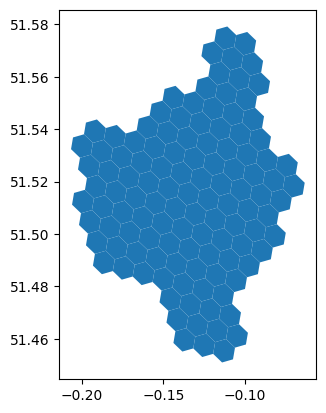

In [62]:
geoms = []
vals = []

for h3_index in visited:
# Tworzenie GeoDataFrame
   
    boundary = h3.h3_to_geo_boundary(h3_index, geo_json=True)
    polygon = Polygon(boundary)
    geoms.append(polygon)
    vals.append(hex_values[h3_index])

gdf = gpd.GeoDataFrame({'duration': vals}, geometry=geoms, crs="EPSG:4326")
gdf.plot()

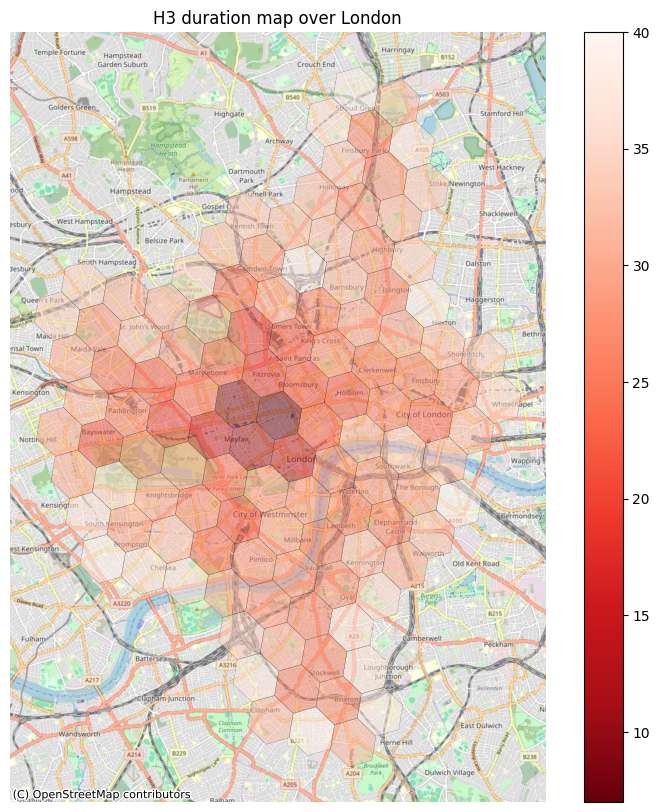

In [64]:
import contextily as ctx
import matplotlib.pyplot as plt

# Konwertuj GeoDataFrame do układu współrzędnych Web Mercator (EPSG:3857)
gdf_web = gdf.to_crs(epsg=3857)

# Tworzenie wykresu
ax = gdf_web.plot(
    column='duration',
    cmap='Reds_r',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    alpha=0.5,
    figsize=(10, 10)
)

# Dodaj mapę podkładową (np. OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Usuwamy osie dla czytelności
ax.set_axis_off()
plt.title("H3 duration map over London")
plt.show()
